In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.path.insert(0, '../scripts')
from utils import *

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [5]:
plt.rcParams['figure.figsize'] = (12, 10)

In [6]:
train_data = pd.read_csv('../data/clean-train.csv').dropna(axis=0)
test_data = pd.read_csv('../data/clean-test.csv').dropna(axis=0)

In [7]:
q1_list = train_data['q1'].tolist()
q2_list = train_data['q2'].tolist()

In [8]:
vocab_size = 10000

In [9]:
token = Tokenizer(nb_words=vocab_size)
token.fit_on_texts(q1_list + q2_list)

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [10]:
question1_seq = token.texts_to_sequences(q1_list)
question2_seq = token.texts_to_sequences(q2_list)

In [11]:
unique_words = {}

for sent in q1_list+q2_list:
    for word in sent.split(' '):
        unique_words[word] = 1.

In [12]:
MAX_SEQUENCE_LENGTH = 25

In [13]:
q1_data = pad_sequences(question1_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(question2_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [14]:
import gensim
from gensim.models import word2vec, Word2Vec

In [15]:
def get_vecs(q1, q2):
    vecs_q1 = []
    vecs_q2 = []

    for i, j in zip(q1, q2):
        vecs_q1.append(sum(model.word_vec(x) if x in model.vocab else np.zeros(300) for x in i))
        vecs_q2.append(sum(model.word_vec(x) if x in model.vocab else np.zeros(300) for x in j))
        
    return np.array(vecs_q1), np.array(vecs_q2)

In [16]:
model = gensim.models.KeyedVectors.load_word2vec_format('../data/glove.w2v.txt')

In [17]:
embed = np.empty((len(unique_words.keys()), 300))

for i, word in enumerate(unique_words.keys()):
    embed[i, :] = model.word_vec(word) if word in model.vocab else np.zeros(300)

In [18]:
from parikh import build_model

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
decomposable_model = build_model(embed, num_class=1, maxlen=25, trainable=True)

In [25]:
decomposable_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [26]:
decomposable_model.count_params()

30770801

In [ ]:
callbacks = [ModelCheckpoint('../Saved Models/decomposable-trainable', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_acc', patience=2)]
decomposable_model.fit([q1_data, q2_data], train_data['is_same'], validation_split=0.1, epochs=100,
                      callbacks=callbacks)

Train on 291067 samples, validate on 32341 samples
Epoch 1/100
194880/291067 [===================>..........] - ETA: 15:32 - loss: 0.5064 - acc: 0.7450

In [33]:
q1_list_test = test_data['q1'].tolist()
q2_list_test = test_data['q2'].tolist()

question1_seq_test = token.texts_to_sequences(q1_list_test)
question2_seq_test = token.texts_to_sequences(q2_list_test)

q1_data_test = pad_sequences(question1_seq_test, maxlen=MAX_SEQUENCE_LENGTH)
q2_data_test = pad_sequences(question2_seq_test, maxlen=MAX_SEQUENCE_LENGTH)

test_labels = test_data['is_same'].values

In [34]:
preds = decomposable_model.predict([q1_data_test, q2_data_test])

In [35]:
classes = (preds > 0.5).astype('int').flatten()

In [36]:
generate_report(test_labels, classes.flatten(), preds.flatten())

Loss Report
-----------

Accuracy Score: 0.8080
ROC  AUC Score: 0.8876
Log Loss Score: 0.4055


(0.80797486828109921, 0.88756163778976505, 0.40546307053140368)

In [23]:
decomposable_model.count_params()

30770801

In [43]:
attn_1 = Model(inputs=decomposable_model.input,
                                 outputs=decomposable_model.layers[8].output)
attn_1_out = attn_1.predict([q1_data_test, q2_data_test])

In [44]:
attn_2 = Model(inputs=decomposable_model.input,
                                 outputs=decomposable_model.layers[10].output)
attn_2_out = attn_2.predict([q1_data_test, q2_data_test])

In [45]:
idx = test_data['is_same'][test_data['is_same'] > 0].index.tolist()

In [63]:
idx = list(set(np.where(preds > 0.5)[0]).intersection(set(idx)))

In [64]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [95]:
def get_sentence(sent):
    if len(sent.split(' ')) < 25:
        temp = ['<UNK>'] * (25 - len(sent.split(' '))) + sent.split(' ')
        return temp
    else:
        return sent.split(' ')[:25]

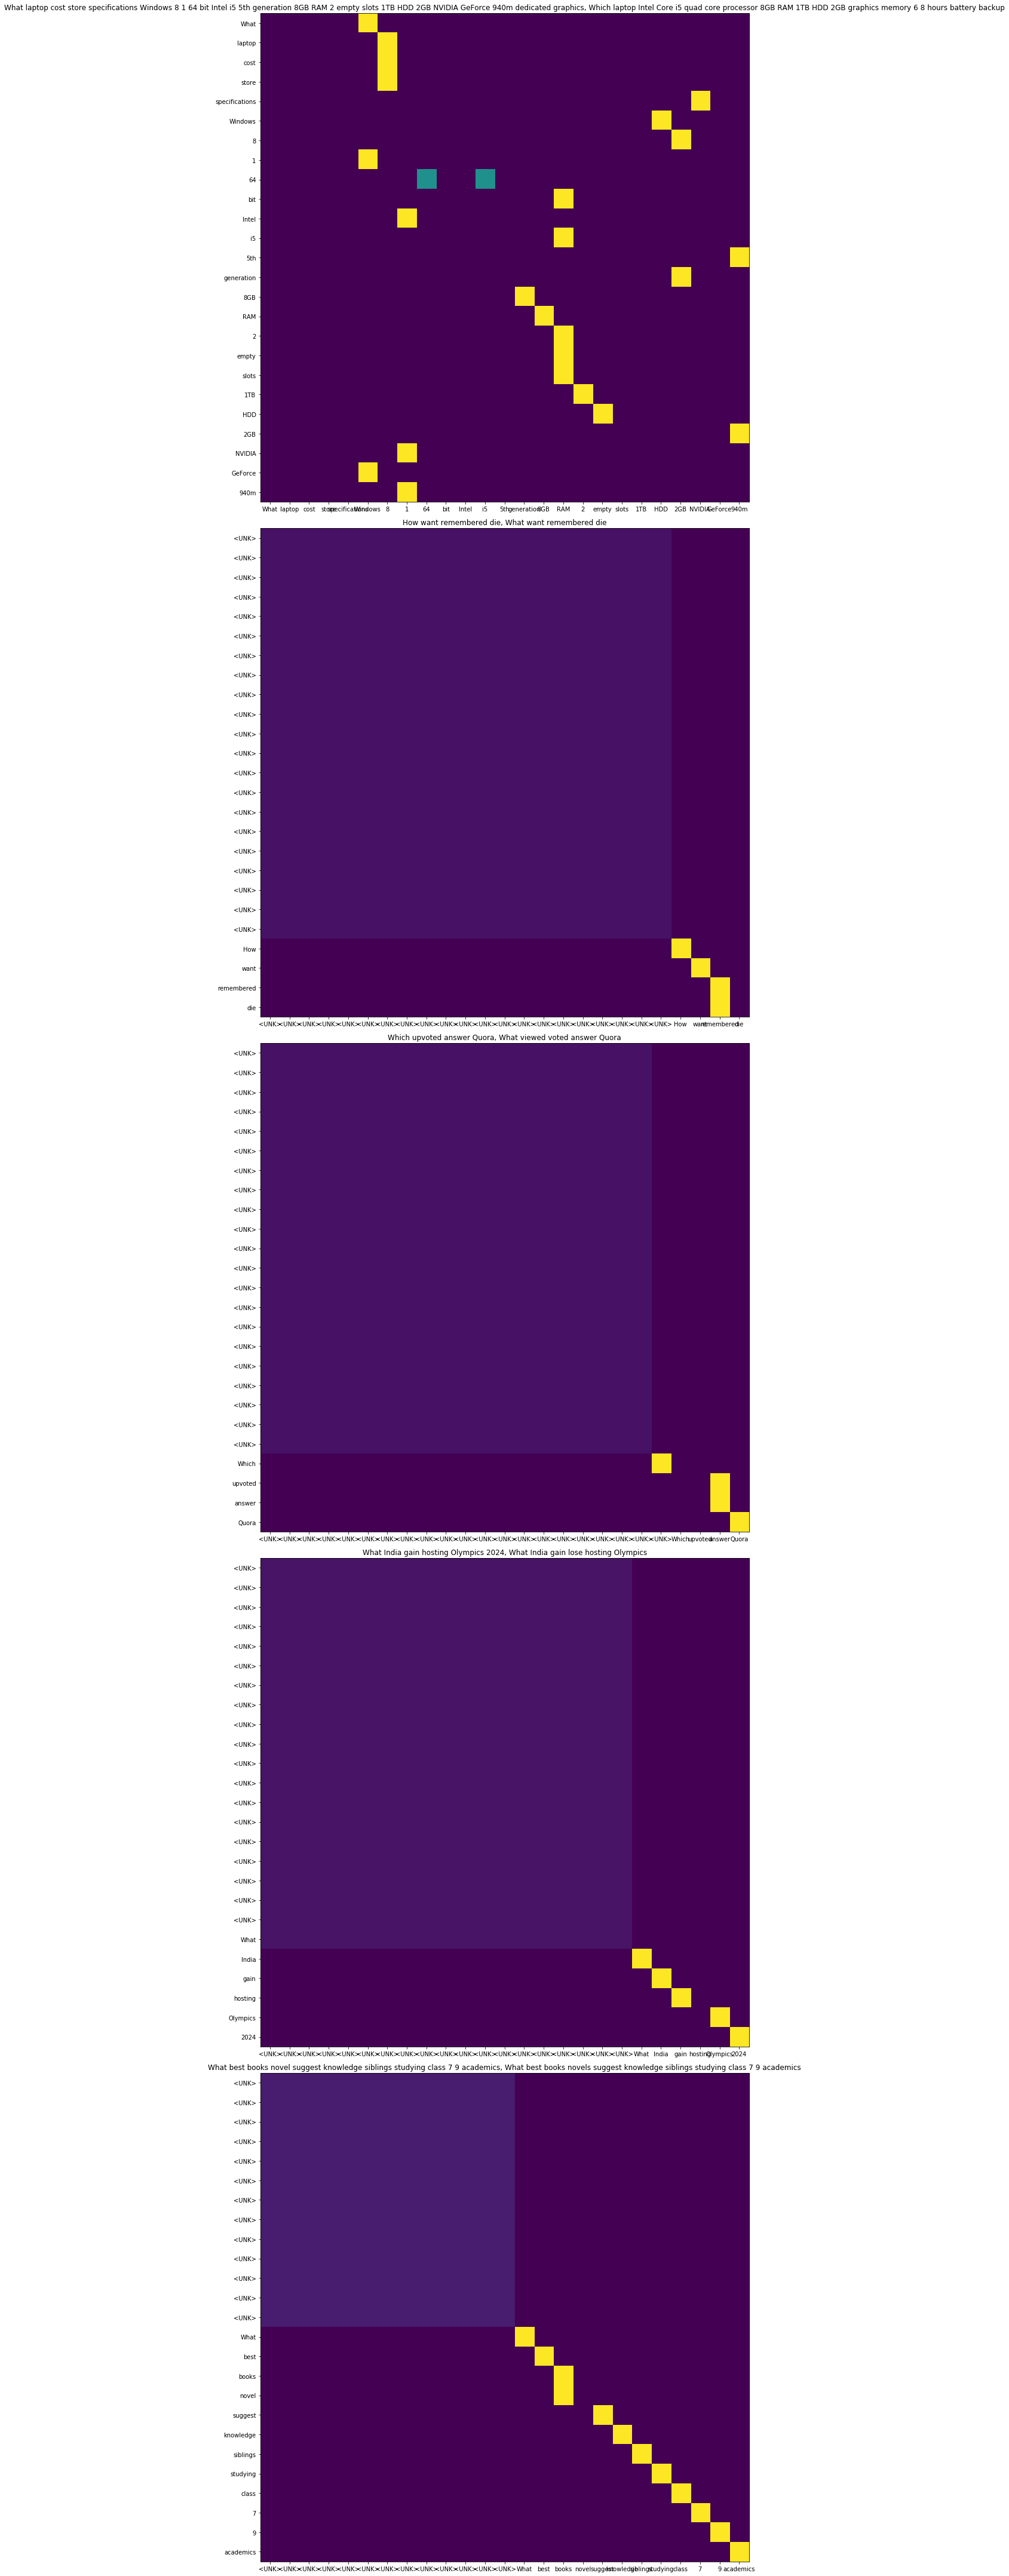

In [101]:
fig, ax = plt.subplots(5, figsize=(20, 60))

for img in np.arange(5):
    i = np.random.choice(idx)
    sent1 = get_sentence(q1_list_test[i])
    sent2 = get_sentence(q1_list_test[i])
    im = ax[img].imshow(attn_1_out[i], cmap='viridis')
    ax[img].set_title(q1_list_test[i] + ', ' + q2_list_test[i])
    ax[img].set_xticks(np.arange(25))
    ax[img].set_xticklabels(sent1)
    ax[img].set_yticks(np.arange(25))
    ax[img].set_yticklabels(sent2)

plt.tight_layout()
plt.savefig('../images/parikh-trainable.png')

In [105]:
idx_wrong = list(set(np.where(preds < 0.5)[0]).intersection(set(test_data['is_same'][test_data['is_same'] > 0].index.tolist())))

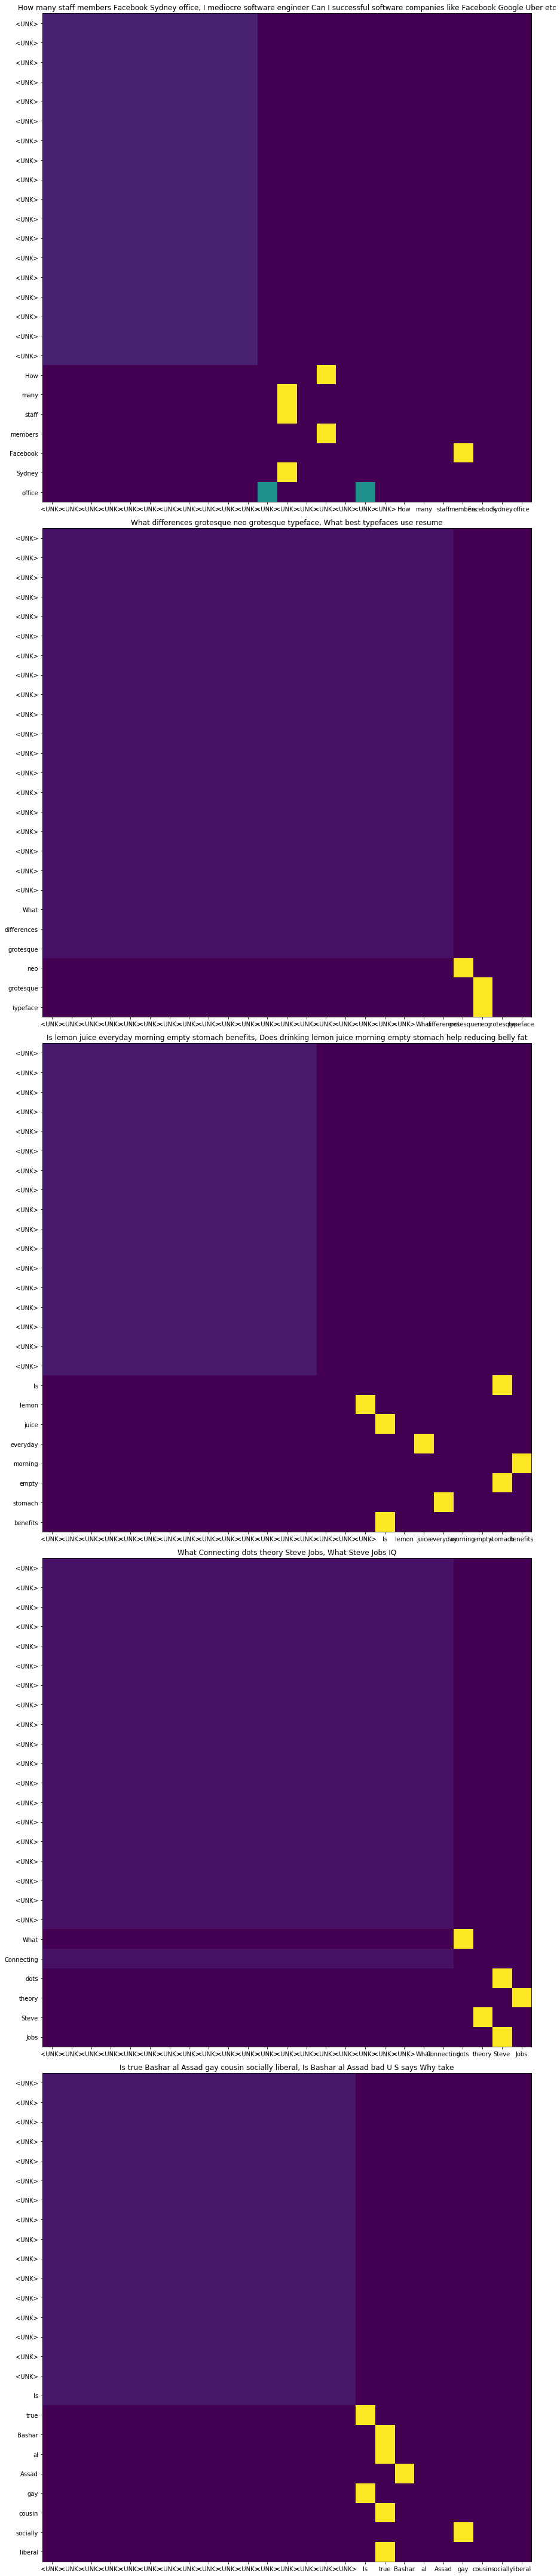

In [107]:
fig, ax = plt.subplots(5, figsize=(20, 60))

for img in np.arange(5):
    i = np.random.choice(idx_wrong)
    sent1 = get_sentence(q1_list_test[i])
    sent2 = get_sentence(q1_list_test[i])
    im = ax[img].imshow(attn_1_out[i], cmap='viridis')
    ax[img].set_title(q1_list_test[i] + ', ' + q2_list_test[i])
    ax[img].set_xticks(np.arange(25))
    ax[img].set_xticklabels(sent1)
    ax[img].set_yticks(np.arange(25))
    ax[img].set_yticklabels(sent2)

plt.tight_layout()
plt.savefig('../images/parikh-trainable-wrong.png')